# Classificazione della qualità dei vini
Per la classificazione delle diverse tipologie di vino abbiamo effettuato un confronto tra i diversi modelli di _apprendimento supervisionato_ con l'obiettivo di trovare il classificatore migliore in grado di determinare il valore più attendibile per il confronto della qualità

Importiamo i moduli e le librerie utili alla realizzazione del sistema

In [1]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
from imblearn.metrics import geometric_mean_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Load del dataset
Carichiamo il dataset in locale e lo visualizziamo

In [2]:
df = pd.read_csv("../Dataset/wine_quality.csv")

df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Pulizia dei dati
## Controllo e pulizia dei valori nulli
Controlliamo la possibile presenza di valori nulli ed eventualmente eliminarli

In [3]:
print(df.isnull().sum())

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


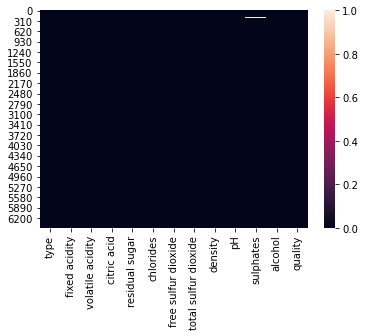

In [4]:
sns.heatmap(df.isnull())

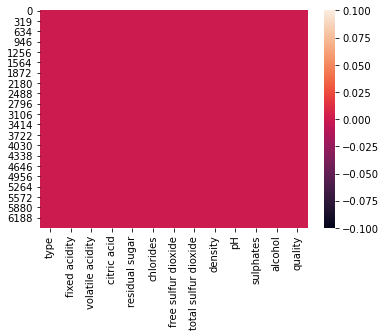

In [5]:
# elimina le righe che contengono valori nulli
df.dropna(axis='index', how='any', inplace=True)

# heatmap per valori nulli
sns.heatmap(df.isnull())

In [6]:
print('Dimensione del dataset processato: ', df.shape)

Dimensione del dataset processato:  (6463, 13)


### Rimozione delle tuple duplicate

In [7]:
df = df.drop_duplicates()
df.reset_index()
df.shape

(5295, 13)

## Normalizzazione delle feature numeriche e categoriche
Selezioniamo le features di interesse normalizziamo il dataset utilizzando la Normalizzazione Min-Max 

In [8]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

for i in df[features]:
    df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())

df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,6
1,white,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,6
2,white,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,6
3,white,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,6
6,white,0.198347,0.160000,0.096386,0.098160,0.059801,0.100694,0.299539,0.150183,0.356589,0.140449,0.231884,6


Trasformiamo la classe 'type' in una feature numerica utilizzando il label encoding

In [9]:
ord_enc = OrdinalEncoder()
df["color"] = ord_enc.fit_transform(df[["type"]]) # assume 1 se bianco 0 se rosso

Tracciamo una Heatmap per rappresentare la correlazione tra le features prese in considerazione

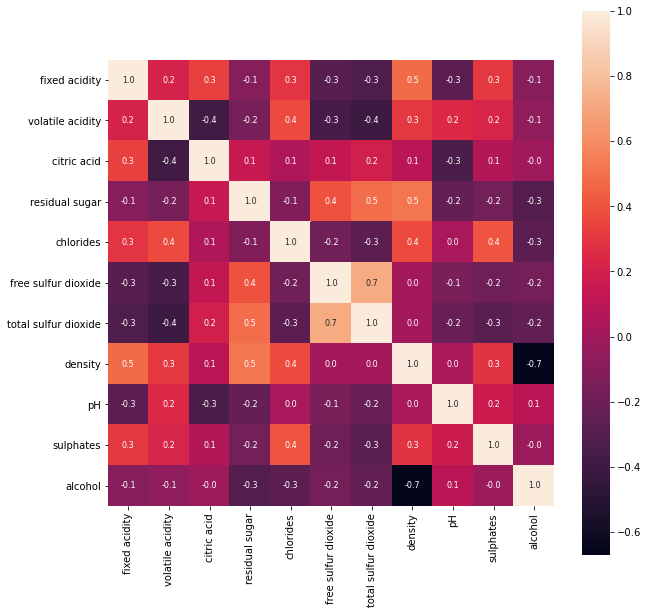

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(df[features].corr(), cbar=True, square=True, fmt = '.1f', annot = True, annot_kws={'size':8})

Come possiamo notare 'density' ha una correlazione negativa leggermente forte con l'alcol. Perciò, questa feature non verrà considerata nella fase di 'costruzione dei modelli e addestramento'.

### Quality Label
Creiamo la quality label basata sulla già esistente colonna 'quality'

- bad per un punteggio minore o uguale di 5
- good per più di 5

In [11]:
df['quality_label'] = df.quality.apply(lambda q: 'bad' if q <= 5 else 'good')

## Distribuzione della classe quality

Osserviamo la correlazione tra la qualità del vino e la percentuale alcolica

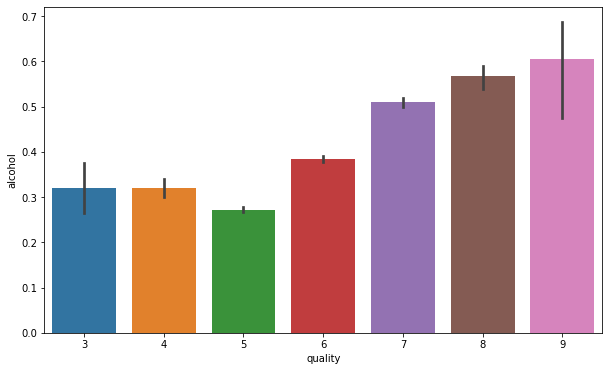

In [12]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'alcohol', data = df)

Come possiamo notare la qualità di un vino cresce all'aumentare del grado alcolico.

Osserviamo ora il bilanciamento della classe quality_label, cioè il target della classificazione:

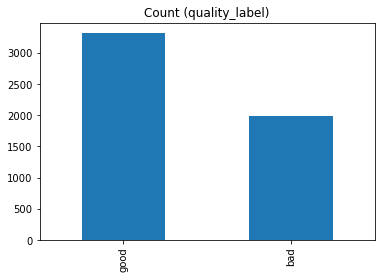

In [13]:
quality_count = df['quality_label'].value_counts()
quality_count.plot(kind='bar', title='Count (quality_label)')

In [14]:
df.quality_label.value_counts()

good    3316
bad     1979
Name: quality_label, dtype: int64

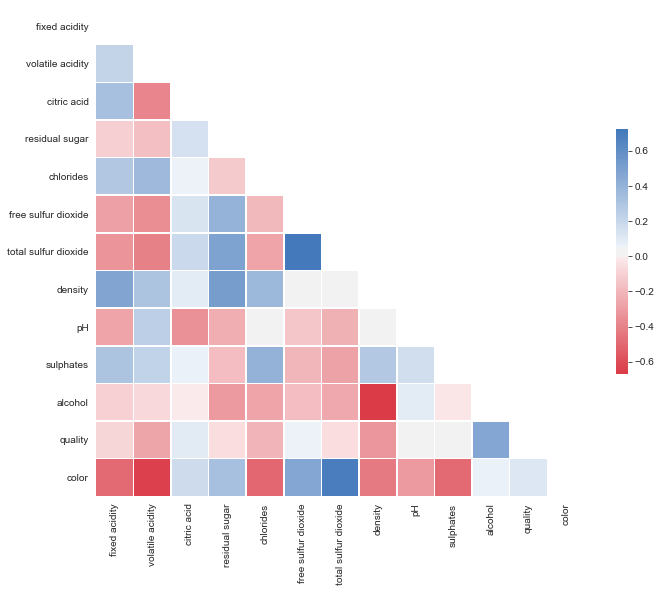

In [15]:
import numpy as np
# chiamo .corr() per calcolare la correlazione a coppie tra le feature del dataframe
corr = df.corr()

# visualizzazione dei dati
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [16]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,quality_label
0,white,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,6,1.0,good
1,white,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,6,1.0,good
2,white,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,6,1.0,good
3,white,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,6,1.0,good
6,white,0.198347,0.160000,0.096386,0.098160,0.059801,0.100694,0.299539,0.150183,0.356589,0.140449,0.231884,6,1.0,good


Utilizziamo la classe LabelEncoder per poter convertire la colonna  'quality_label' in feature numerica

In [17]:
ord_enc = OrdinalEncoder()
df["quality_label"] = ord_enc.fit_transform(df[["quality_label"]]) # assume 1 se good 0 se bad
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,quality_label
0,white,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,6,1.0,1.0
1,white,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,6,1.0,1.0
2,white,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,6,1.0,1.0
3,white,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,6,1.0,1.0
6,white,0.198347,0.160000,0.096386,0.098160,0.059801,0.100694,0.299539,0.150183,0.356589,0.140449,0.231884,6,1.0,1.0


# Costruzione dei modelli & Addestramento
## Preparazione del dataset
Prenderemo come target la colonna 'quality_label' per una maggiore accuratezza. Avendo già convertito questo attributo categorico utilizzando la classe LabelEncoder, possiamo procedere alla costruzione dei vari modelli di classificazione ed addestramento.

In [18]:
print(df['quality_label'].value_counts())

1.0    3316
0.0    1979
Name: quality_label, dtype: int64


## Divisione del dataset

Dividiamo ora il dataset in train e test considerando soltanto le feature che hanno più importanza, infatti la densità non verrà considerata per questo esperimento. Così facendo viene ridotta la complessità dei vari modelli.

In [19]:
X = df.drop(['type','quality_label','quality','density'], axis = 1)
y = df['quality_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 11)

## Modello Lineare
Come primo modello utilizziamo la regressione lineare, che è un modello lineare per la classificazione piuttosto che la regressione

In [20]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

#Calcolo il coefficiente angolare
print(regr.coef_)

[ 0.01127909 -1.22669388 -0.04962385  0.53405673 -0.17510973  0.94868818
 -0.59011264  0.17429411  0.58305547  1.09510729 -0.01133984]


In [21]:
#Questo è il valore di R^2
regr.score(X_train, y_train)

0.2485399360386935

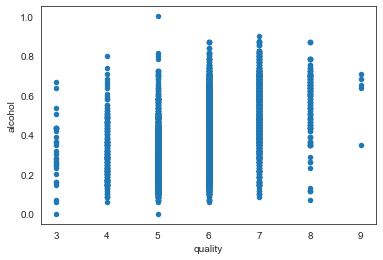

In [22]:
df.plot.scatter(x = 'quality', y = 'alcohol')


In [23]:
# Valutiamo le prestazioni del modello e visualizziamo i risultati
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.1631485481875093
R-squared Score: 0.2964501162410941


# Regressione Logistica



Tramite questo classificatore possiamo calcolare la probabilità che un determinato evento avvenga all'interno del dataset.

Creiamo un pipeline dove vengono svolte in maniere consequenziale le seguenti azioni:

- Scaler un'operazione di standardizzazione delle feature
- Classifier è il modello che verrà utilizzato per l'apprendimento, in questo caso Regressione Logistica

La costruzione del classificatore avviene nel seguente modo: si crea un oggetto della classe LogisticRegression e successivamente viene chiamato il metodo fit, specificando come argomenti le osservazioni e le corrispondenti etichette. Infine invochiamo il metodo predict passando come argomento una lista di oggetti da classificare.

In [24]:
pipeline = imbpipeline(steps = [['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression()]])

Creiamo un'istanza per poter specificare il tipo di Cross Validation

In [25]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=5)

### Parameter tuning

Definiamo l'insieme degli iper-parametri, su cui verrà effettuato un tuning durante la fase di test, al fine di migliorare le performance.

Creiamo un'istanza della classe GridSearchCV, che ci permetterà ci combinare la cross validation con la pipeline.

In [26]:
# in param_grid sono definiti gli iperparametri

n_components= [10, 12]
whiten = [True] #, False]
C =  [0.003, 0.009, 0.01]#, 0.1, 1.0, 10.0, 100.0, 1000.0]
tol = [0.001, 0.0001] # [1e-06, 5e-07, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01]

param_grid =\
    [{'classifier__C': C
     ,'classifier__solver': ['liblinear', 'saga'] 
     ,'classifier__penalty': ['l1', 'l2']
     ,'classifier__tol' : tol 
     ,'classifier__class_weight': [None, 'balanced']
},
    {'classifier__C': C
     ,'classifier__max_iter': [3, 9, 2, 7, 4]
     ,'classifier__solver': ['newton-cg', 'sag', 'lbfgs']
     ,'classifier__penalty': ['l2']
     ,'classifier__tol' : tol 
     ,'classifier__class_weight': [None, 'balanced'] 
}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose=1,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili



### Ricerca dei parametri migliori

In [27]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 228 candidates, totalling 684 fits
Best parameters: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'classifier__tol': 0.001}
Cross-validation score: 0.6940509915014165


Le metriche che considereremo per ogni modello saranno:

- accuracy
- recall
- precision
- f1
- matthews correlation coefficent
- geometric mean score

accuracy: 0.71671388101983
precision: 0.7050360490266763
recall: 0.7187038575119971
f1: 0.7065593272939542
matthews_corrcoef: 0.4235194203393892
geometric_mean_score: 0.7187038575119971


[]

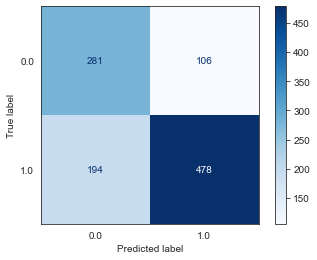

In [28]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [29]:
scoring_list = []
scoring_list.append(dict([
    ('Model', 'LogisticRegression'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

## Naive Bayes
Tramite questo classificatore possiamo calcolare la probabilità che un determinato evento avvenga all'interno del dataset.

Creiamo un pipeline dove vengono svolte in maniere consequenziale le seguenti azioni:

- SMOTE (synthetic minority oversampling technique) un'operazione di oversampling sul set di training, in modo da risolvere il problema dello sbilanciamento dei dati
- Scaler un'operazione di standardizzazione delle feature
- Classifier è il modello che verrà utilizzato per l'apprendimento, in questo caso Naive Bayes

La costruzione del classificatore avviene nel seguente modo: si crea un oggetto della classe GaussianNB e successivamente viene chiamato il metodo fit, specificando come argomenti le osservazioni e le corrispondenti etichette. Infine invochiamo il metodo predict passando come argomento una lista di oggetti da classificare.

In [30]:
pipeline = imbpipeline(steps = [['scaler', MinMaxScaler()],
                                ['classifier', GaussianNB()]]) 

Istanziamo un oggetto della classe StratifiedKFold che ci permetterà di andare a definire un tipo di Cross Validation

In [31]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=5)

In [32]:
# in param_grid sono definiti gli iperparametri
param_grid = {}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 1,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


accuracy: 0.7148253068932956
precision: 0.6919910758808054
recall: 0.6717365725359912
f1: 0.6773295936074902
matthews_corrcoef: 0.3631632653739468
geometric_mean_score: 0.6717365725359912


[]

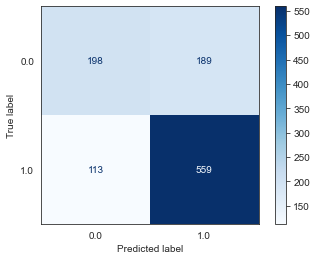

In [33]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [34]:
scoring_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

## Random Forest
Useremo il Random Forest della libreria scikit-learn, che calcola la media della previsione probabilistica di tutti gli alberi nella foresta per la previsione finale invece di prendere i voti di previsione effettivi e quindi calcolarne la media

In [35]:
pipeline = imbpipeline(steps = [['scaler', MinMaxScaler()],
                                ['classifier', RandomForestClassifier(max_depth=12, random_state=11)]])

In [36]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Parameter Tuning

In [37]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50,100, 200],
                'max_depth': [6,10, 12]
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [38]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'classifier__max_depth': 12, 'classifier__n_estimators': 200}
Cross-validation score: 0.7655807365439093


accuracy: 0.7988668555240793
precision: 0.784799892197817
recall: 0.776312753783684
f1: 0.7800164036587376
matthews_corrcoef: 0.5610484559838844
geometric_mean_score: 0.776312753783684


[]

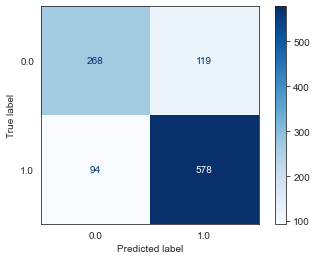

In [39]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [40]:
scoring_list.append(dict([
    ('Model', 'RandomForest'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

## KNN

In [41]:
pipeline = imbpipeline(steps = [['scaler', MinMaxScaler()],
                                ['classifier',KNeighborsClassifier()]]) 

In [42]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Parameter tuning

In [43]:
# in param_grid sono definiti gli iperparametri
param_grid = {
         'n_neighbors': [10, 11, 12, 13] ,
         'weights': ['distance'],
         'algorithm' : ['ball_tree'], #, 'brute', 'auto',  'kd_tree', 'ball_tree']
         'leaf_size': [12, 11, 13],
         'p': [1]
}


new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [44]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 12, 'classifier__n_neighbors': 13, 'classifier__p': 1, 'classifier__weights': 'distance'}
Cross-validation score: 0.7504721435316336


accuracy: 0.7752596789423984
precision: 0.7605764503441494
recall: 0.7445609542266518
f1: 0.750599648522846
matthews_corrcoef: 0.504883453264846
geometric_mean_score: 0.7445609542266518


[]

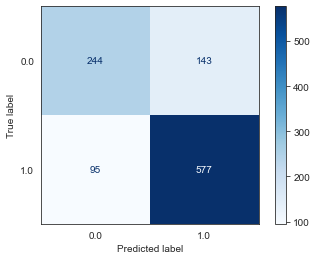

In [45]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [46]:
scoring_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

## Support Vector Machine

In [47]:
pipeline = imbpipeline(steps = [['scaler', MinMaxScaler()],
                                ['classifier',SVC(kernel=None,
                                                  gamma=None, 
                                                  C=None)]])
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Parameter tuning

In [48]:
# in param_grid sono definiti gli iperparametri
param_grid = {'C': [0.08, 0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'] # linear
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [49]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'classifier__C': 100, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Cross-validation score: 0.7530689329556184


accuracy: 0.7828139754485364
precision: 0.7697884884967428
recall: 0.7516092192691031
f1: 0.7583419981109463
matthews_corrcoef: 0.5210806884099883
geometric_mean_score: 0.7516092192691031


[]

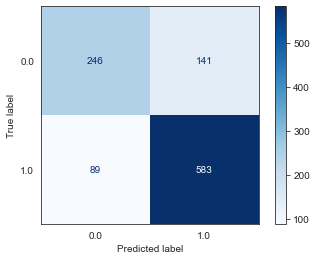

In [50]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [51]:
scoring_list.append(dict([
    ('Model', 'SVM'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

# Confronto dei vari modelli

In [52]:
results = pd.DataFrame(data=scoring_list)
results = results[['Model',
                   'Train Accuracy',
                   'Test Accuracy',
                   'Precision',
                   'Recall',
                   'F1',
                   'Matthews Corrcoef',
                   'Geometric Mean Score']]

results = results.sort_values(by='Recall', ascending=False)

print(results)

                Model  Train Accuracy  Test Accuracy  Precision  Recall  \
2        RandomForest           0.766          0.799      0.785   0.776   
4                 SVM           0.753          0.783      0.770   0.752   
3                 KNN           0.750          0.775      0.761   0.745   
0  LogisticRegression           0.694          0.717      0.705   0.719   
1         Naive Bayes           0.676          0.715      0.692   0.672   

      F1  Matthews Corrcoef  Geometric Mean Score  
2  0.780              0.561                 0.776  
4  0.758              0.521                 0.752  
3  0.751              0.505                 0.745  
0  0.707              0.424                 0.719  
1  0.677              0.363                 0.672  


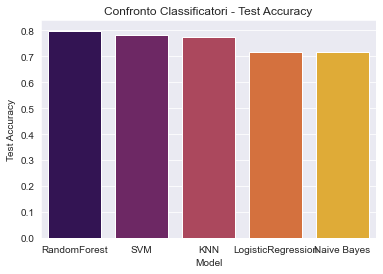

In [53]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Test Accuracy'],
                palette = 'inferno').set(title = "Confronto Classificatori - Test Accuracy")

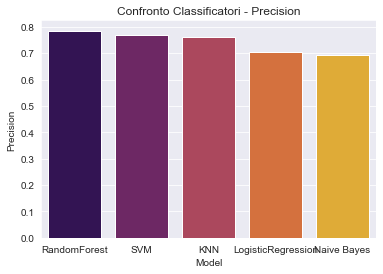

In [54]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Precision'],
                palette = 'inferno').set(title = "Confronto Classificatori - Precision")

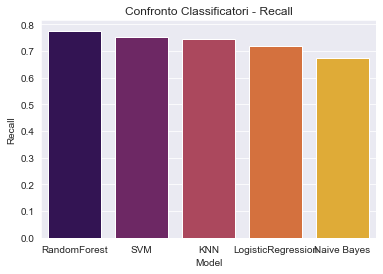

In [55]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Recall'],
                palette = 'inferno').set(title = "Confronto Classificatori - Recall")

Come possiamo vedere dai grafici precedenti, il modello migliore è risultato il Random Forest con indice di profondità pari a 12. Nel complesso quasi tutti i modelli si sono comportati circa in egual modo, a differenza del Naive Bayes che ha restiuito un Accuracy dell'70% circa